This file was created by David Neufeld.

# Feature Extraction

In [1]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
from sklearn.model_selection import train_test_split
import dataset



In [2]:
def visualize_images(images, png=True):
    # Give this function any number of images or depth maps
    # and it will display them in a grid.

    if not png:
        images = [np.transpose(img, (1, 2, 0)) for img in images]
    n = len(images)
    # Calculate number of rows and columns
    width = math.ceil(math.sqrt(n))
    height = math.ceil(n / width)
    plt.figure(figsize=(17.5, 5))
    fig, axes = plt.subplots(height, width)
    plt.subplots_adjust(wspace=0, hspace=0)
    if n == 1:
        axes.imshow(images[0])
        axes.axis('off')
        return
    for i, ax in enumerate(axes.flatten()):
        if(i<n): 
            # Display image
            image = images[i]

            #Scale pixel values from 0-1 to 0-255 if necessary
            if not png:
                image = (image * 255)
            
            ax.imshow(image)
            ax.axis('off')
        else:
            # Hide axis if no image
            ax.axis('off')
    fig.set_size_inches(17.454545*width, 5*height)
    plt.show()

def visualize_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, marker='o', linestyle='-')
    plt.title('Training Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

def load_image(file_path):
    return Image.open(file_path)

def load_depth(file_path):
    return Image.open(file_path)

class MinMaxNormalize(object):
    def __call__(self, tensor):
        return (tensor - tensor.min()) / (tensor.max() - tensor.min())
    
class DivBy255(object):
    def __call__(self, tensor):
        return tensor / 255

<Figure size 1750x500 with 0 Axes>

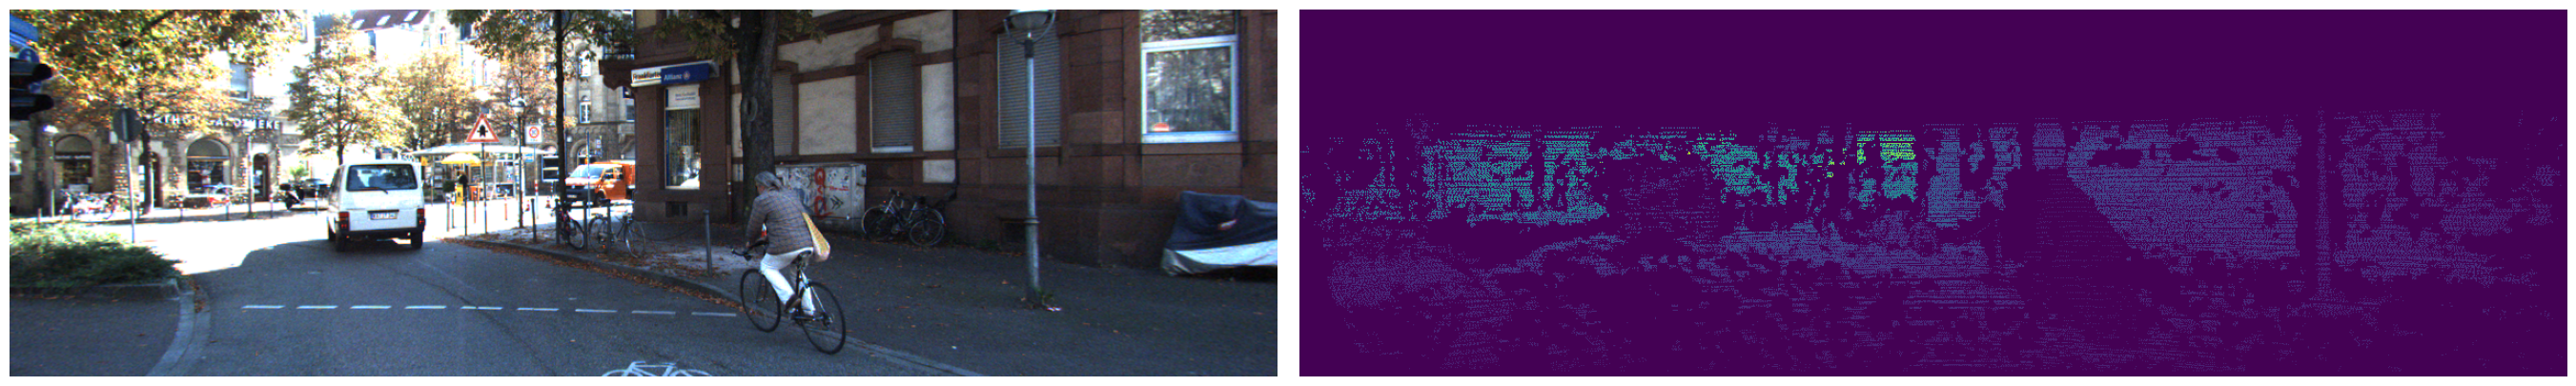

In [3]:
# Set Directories
base_dir = 'dataset'
image_dir = os.path.join(base_dir, 'image')
depth_dir = os.path.join(base_dir, 'groundtruth_depth')

image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir)])
depth_files = sorted([os.path.join(depth_dir, file) for file in os.listdir(depth_dir)])

# Ensure that the lists are aligned and have the same length
assert len(image_files) == len(depth_files), "The number of images and depth maps should be the same"

# Load the data into variables
images = [load_image(file) for file in image_files]
depth_maps = [load_depth(file) for file in depth_files]
data = list(zip(images, depth_maps))

# Visualize a sample from the dataset
visualize_images([images[30], depth_maps[30]])

In [4]:
def display_two_images(image1, image2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with two subplots
    
    # Display the first image on the left subplot
    axes[0].imshow(image1)
    # axes[0].set_title('Image 1')
    
    # Display the second image on the right subplot
    axes[1].imshow(image2)
    # axes[1].set_title('Image 2')
    
    # Hide axis ticks and labels for better visualization
    for ax in axes:
        ax.axis('off')
    
    plt.show()

<Figure size 1750x500 with 0 Axes>

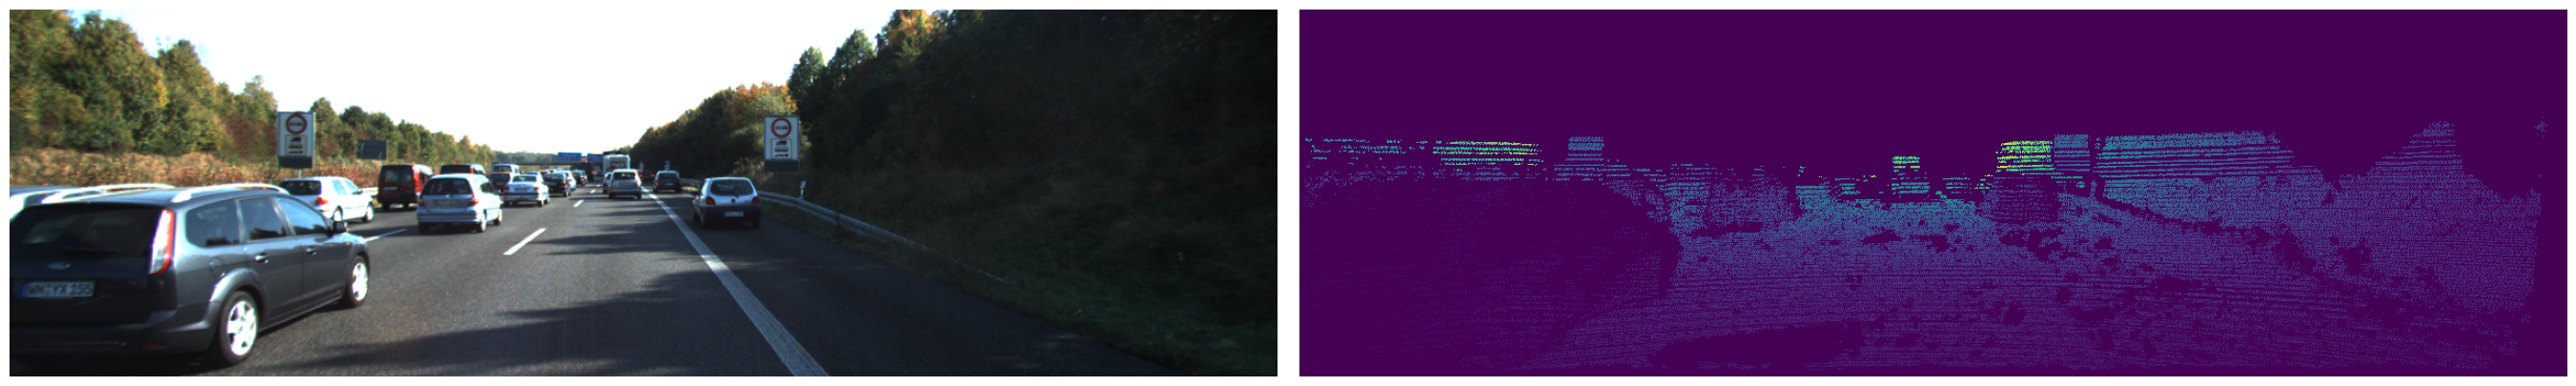

<Figure size 1750x500 with 0 Axes>

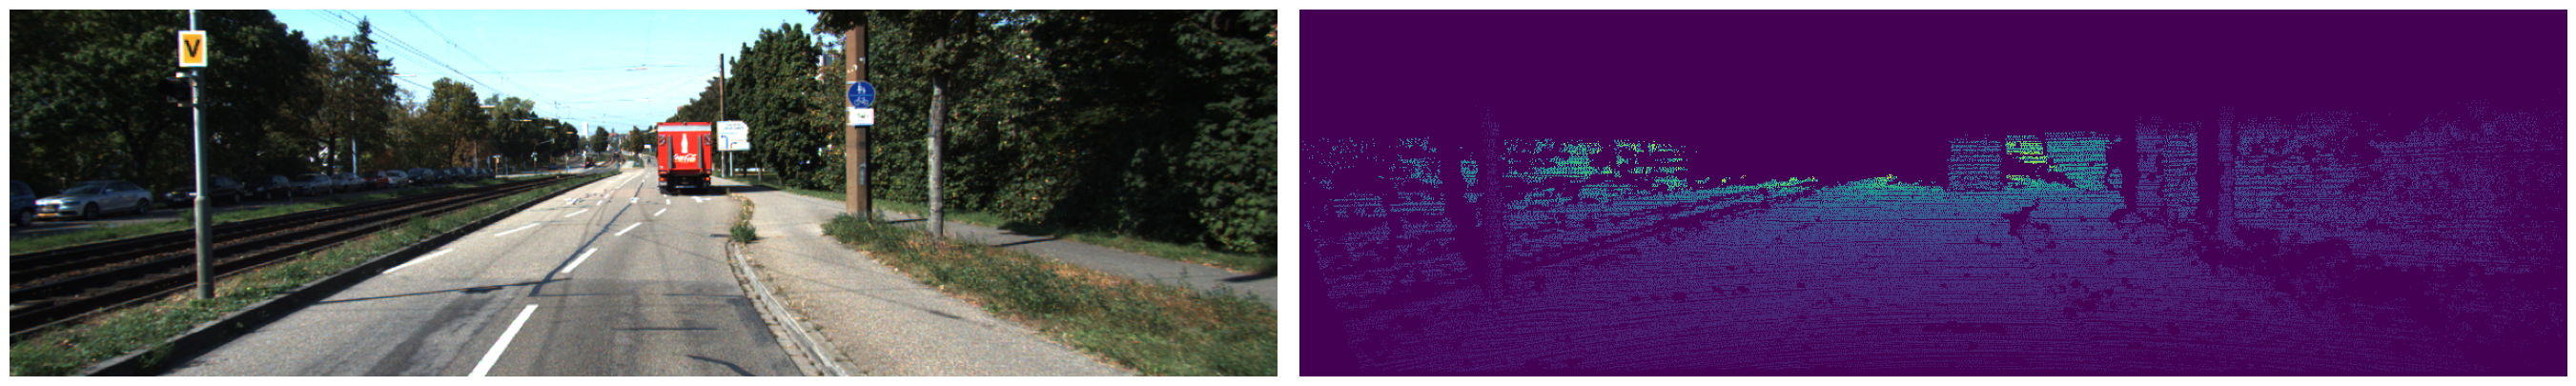

<Figure size 1750x500 with 0 Axes>

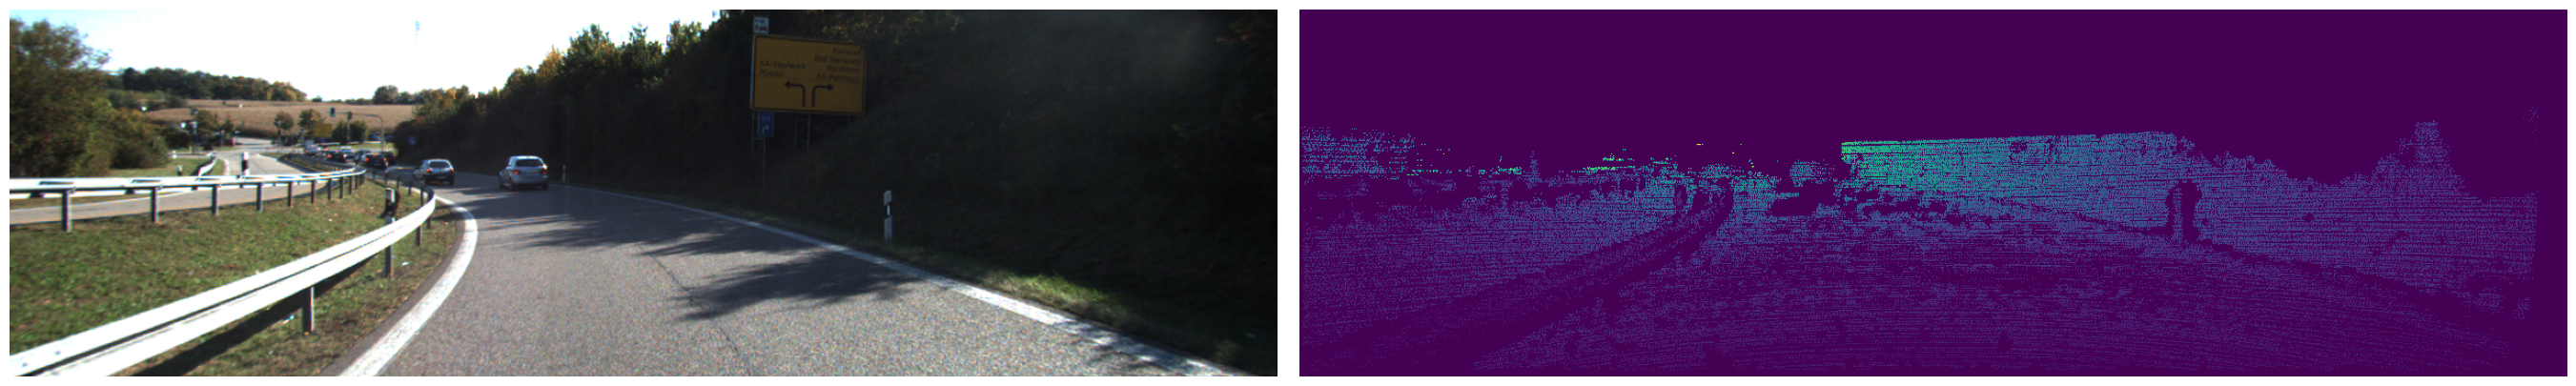

In [5]:
# define image transformation
transform = transforms.Compose([
    transforms.Resize((352, 1216)),
    transforms.ToTensor(),
    DivBy255()
])

train, test = train_test_split(data, test_size=0.20, random_state=42)
train, val = train_test_split(train, test_size=0.15, random_state=42)

train_dataset = dataset.DepthDataset(train, transform)
val_dataset = dataset.DepthDataset(val, transform)
test_dataset = dataset.DepthDataset(test, transform)

batch_size = 8
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# dataiter = iter(trainloader)
# images_batch1, labels_batch1 = next(dataiter)

# # Print the first two examples
# image1 = np.transpose(images_batch1[0], (1, 2, 0))
# image2 = np.transpose(labels_batch1[0], (1, 2, 0))
# visualize_images([image1, image2], png=False)

# Print the first two train, val, and test examples
dataiter = iter(trainloader)
images_batch1, labels_batch1 = next(dataiter)
visualize_images([images_batch1[0], labels_batch1[0]], png=False)
dataiter = iter(valloader)
images_batch1, labels_batch1 = next(dataiter)
visualize_images([images_batch1[0], labels_batch1[0]], png=False)
dataiter = iter(testloader)
images_batch1, labels_batch1 = next(dataiter)
visualize_images([images_batch1[0], labels_batch1[0]], png=False)


In [6]:
def load_model(removed_layers = 1):
    # Load Pre-Trained Model
    model = models.resnet18(pretrained=True)
    #model = model.to("cpu")
    #remove final connected layers from model
    #model.fc = nn.Identity()
    model = torch.nn.Sequential(*list(model.children())[:-removed_layers])
    return model
# Function to extract features
def extract_features(dataloader, model = load_model(1)):
    features = []
    with torch.no_grad(): #Disables gradient calcullation
        for inputs, _ in dataloader:
            outputs = model(inputs)
            features.append(outputs.flatten(1))
    return torch.cat(features)
features = extract_features(trainloader, load_model(3))
features.shape

C:\Users\20neu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\20neu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([680, 428032])

# Manifold Learning

In [16]:
#Dimension Reduction with LLE
import matplotlib.pyplot as plt
from sklearn.manifold import LocallyLinearEmbedding
def LLE(data, n_components, n_neighbors):
    lle = LocallyLinearEmbedding(n_components = n_components, n_neighbors = n_neighbors, method='standard')
    lle_features = lle.fit_transform(data)
    return lle_features
lle_features_skt = LLE(features, 150, 25)
print(f'Reduced feature matrix: {lle_features_skt.shape}')

Reduced feature matrix: (680, 150)
Calculated weights: (680, 150)


In [17]:
from sklearn.neighbors import NearestNeighbors

def lle_manual(data, n_neighbors, n_components):
    # Finding the nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(data)
    distances, indices = nbrs.kneighbors(data)
    
    n_samples, n_features = data.shape
    weights = np.zeros((n_samples, n_neighbors))

    for i in range(n_samples):
        neighbors = data[indices[i]]
        gram_matrix = np.dot(neighbors - data[i], (neighbors - data[i]).T)
        gram_matrix += np.eye(n_neighbors) * 1e-3  # Adding small regularization term
        w = np.linalg.solve(gram_matrix, np.ones(n_neighbors))
        weights[i] = w / w.sum()

    # Compute the embedding matrix
    embedding_matrix = np.eye(n_samples) - weights @ weights.T
    _, eigvecs = np.linalg.eig(embedding_matrix)
    return eigvecs[:, 1:n_components+1], weights  # Exclude the first eigenvector

# Applying the manual LLE
lle_features_manual, lle_weights = lle_manual(features, n_neighbors=25, n_components=150)

# Now print the reduced feature matrix and compute depth maps
print(f'Reduced feature matrix: {lle_features_manual.shape}')
print(f'Calculated weights: {lle_weights.shape}')
# Further processing for depth maps...


Reduced feature matrix: (680, 150)
Calculated weights: (680, 25)


In [ ]:
def reconstruct_depthmap(weights, n_neighbors, gt_depth_maps):
    estimated_depth_map = np.zeros(gt_depth_maps[0].shape)
train_dataset.__getitem__()

In [13]:
reconstructed_depths = np.dot(np.transpose(lle_weights), lle_features)
print("Reconstructed depth maps:", reconstructed_depths.shape)

Reconstructed depth maps: (25, 150)
